In [ ]:
# Importing required libraries
#from fastai.structured import  add_datepart
#from fastai.tabular import *
from keras.models import Sequential
from keras.layers import Dense
import xgboost as xgb
from sklearn import tree, neighbors, datasets, linear_model, svm, naive_bayes, ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.multiclass import unique_labels
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [73]:
def model_fit(alg,x_train,x_test,y_train,y_test):
    #fit model
    alg.fit(x_train,y_train)
    
    #predict using model
    y_train_predict=alg.predict(x_train)
    y_test_predict=alg.predict(x_test)

    
    #print report
    print("Training R-squared: ",round(metrics.r2_score(y_train,y_train_predict),2))
    print("Training Explained Variation: ",round(metrics.explained_variance_score(y_train,y_train_predict),2))
    print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(y_train,y_train_predict)),2))
    print("Training MAE: ",round(metrics.mean_absolute_error(y_train,y_train_predict),2)," \n")
    
    
    # Calculate accuracy score on predicted values
    print("Test R-squared: ",round(metrics.r2_score(y_test,y_test_predict),2))
    print("Test Explained Variation: ",round(metrics.explained_variance_score(y_test,y_test_predict),2))
    print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(y_test,y_test_predict)),2))
    print("Test MAE: ",round(metrics.mean_absolute_error(y_test,y_test_predict),2))
    

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    #plt.figure(figsize=(20,20))
    #plt.show()
    
    return y_train_predict,y_test_predict,feat_imp

In [79]:
def predict_soybean_futures(filename = "ac_may_merged.csv", lag_prices = 7, lag_tweets = 3, forex = False, printlogs = True):
    
    #reading files
    close_merge =pd.read_csv(filename)
    tweet=pd.read_csv("Trump.csv",sep="\t",parse_dates=[0])
    crude_forex=pd.read_csv("crude_forex.csv")
    
    #adding date index
    tweet.index=tweet.Date
    close_merge.index= close_merge.Date
    crude_forex.index=crude_forex.Date
    
    #merging data
    data = pd.merge(close_merge,
                     tweet,
                     how='left',
                     left_index=True,
                    right_index=True)
    
    data=data.drop(columns=['Date_y'])
    data.columns= ['Date', 'Close', 'Agricultural Exports', 'Merchandise Exports',
           'Retweets', 'Favorites', 'Negetive', 'positive', 'Neutral']
    if printlogs == True:
        print('preparing your data')
    #reoving columns that are not required
    data=data.drop(columns=['Retweets', 'Favorites','Date'])
    #forex removed based on user input
    if forex == False:
        data=data.drop(columns=['Agricultural Exports','Merchandise Exports'])
    
    #adding lags to tweets and prices
    lags = range(1, lag_prices)
    lag_col= ['Close']
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    lags = range(1, lag_tweets)
    lag_col= ['Negetive', 'positive', 'Neutral']
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(t)
        for t in lags
        for col in lag_col
    })
    
    rows_removed_lag = max(lag_tweets,lag_prices) + 1
    data=data.iloc[rows_removed_lag:,]
    
    rows,cols = data.shape
    
    #train test splits
    split = int(0.75*rows)
    
    train=data.iloc[:split,]
    test=data.iloc[split:,]
    
    train_y=train[['Close']]
    train_x=train.loc[:,train.columns != 'Close']
    
    test_y=test[['Close']]
    test_x=test.loc[:,test.columns != 'Close']
    if printlogs == True:
        print('optimizing parameters step 1 of 5')
    # xg boost parameter tuning
    # Grid Search for best parameters
    param_test = {'max_depth':list(range(3,10,2)), 
                  'min_child_weight':list(range(1,6,2))}
    
    gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                    n_estimators=45,
                                                    max_depth=9,
                                                    min_child_weight=1,
                                                    gamma=0,
                                                    subsample=0.8,
                                                    colsample_bytree=0.8,
                                                    njobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=123),
                          param_grid=param_test,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          iid=True,
                          cv=5)
    
    gsearch.fit(train_x,train_y)
    if printlogs == True:
        print("Best Score:",gsearch.best_score_)
        print("Best parameters:",gsearch.best_params_)
        print('optimizing parameters step 2 of 5')

    maxDepth = gsearch.best_params_['max_depth']
    minChildWeight = gsearch.best_params_['min_child_weight']
    

    param_test = {'learning_rate':list(np.arange(0.01,2,0.05)), 
              'n_estimators':list(range(5,50,5))}

    gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                    n_estimators=45,
                                                    max_depth=maxDepth,
                                                    min_child_weight=minChildWeight,
                                                    gamma=0,
                                                    subsample=0.8,
                                                    colsample_bytree=0.8,
                                                    njobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=123),
                          param_grid=param_test,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          iid=True,
                          cv=5)
    
    gsearch.fit(train_x,train_y)
    if printlogs == True:
        print("Best Score:",gsearch.best_score_)
        print("Best parameters:",gsearch.best_params_)
        print('optimizing parameters step 3 of 5')
    learningRate = gsearch.best_params_['learning_rate']
    nEstimators = gsearch.best_params_['n_estimators']
    
    # Grid Search for best parameters
    param_test = {'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)],
             'colsample_bylevel':[i/10.0 for i in range(6,11)], 
              'colsample_bynode':[i/10.0 for i in range(6,11)]}
    
    gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=learningRate,
                                                    n_estimators=nEstimators,
                                                    max_depth=maxDepth,
                                                    min_child_weight=minChildWeight,
                                                    gamma=0,
                                                    subsample=0.8,
                                                    colsample_bytree=0.8,
                                                    njobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=123),
                          param_grid=param_test,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          iid=True,
                          cv=5)
    
    gsearch.fit(train_x,train_y)
    if printlogs == True:
        print("Best Score:",gsearch.best_score_)
        print("Best parameters:",gsearch.best_params_)
        print('optimizing parameters step 4 of 5')
    subAample = gsearch.best_params_['subsample']
    colsampleBytree = gsearch.best_params_['colsample_bytree']
    colsampleBylevel = gsearch.best_params_['colsample_bylevel']
    colsampleBynode = gsearch.best_params_['colsample_bynode']
    
    param_test = {'reg_alpha':[0.1, 1,0.01,0.001,0.0001]}

    gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=learningRate,
                                                    n_estimators=nEstimators,
                                                    max_depth=maxDepth,
                                                    min_child_weight=minChildWeight,
                                                    gamma=0,
                                                    subsample=subAample,
                                                    colsample_bytree=colsampleBytree,
                                                    njobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=123,
                                                   colsample_bylevel=colsampleBylevel,
                                                   colsample_bynode=colsampleBynode),
                          param_grid=param_test,
                          scoring='neg_mean_squared_error',
                          n_jobs=-1,
                          iid=True,
                          cv=5)
    
    gsearch.fit(train_x,train_y)
    if printlogs == True:
        print("Best Score:",gsearch.best_score_)
        print("Best parameters:",gsearch.best_params_)
        print('optimizing parameters step 5 of 5')
    regAlpha = gsearch.best_params_['reg_alpha']
    xgb_model=xgb.XGBRegressor(learning_rate=learningRate,
                                                    n_estimators=nEstimators,
                                                    max_depth=maxDepth,
                                                    min_child_weight=minChildWeight,
                                                    gamma=0,
                                                    subsample=subAample,
                                                    colsample_bytree=colsampleBytree,
                                                    njobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=123,
                                                   colsample_bylevel=colsampleBylevel,
                                                   colsample_bynode=colsampleBynode,
                                                   reg_alpha = regAlpha)
    if printlogs== True:
        print('Predicting....')

    train_predict,test_predict,feat_imp = model_fit(xgb_model,train_x,test_x,train_y,test_y)
    feat_imp[feat_imp>2]
    
    test_result=test_y
    test_result['predict']=test_predict
    test_result['diff']=test_result['Close']-test_result['predict']
    test_result.describe()
    
    #plt.plot(train['Close'])
    #plt.plot(test_result[['Close', 'predict']])
    #plt.show()

In [81]:
#run specific combination
predict_soybean_futures(filename = "ac_march_merged.csv", lag_prices = 10, lag_tweets = 5, forex = True)

preparing your data
optimizing parameters step 1 of 5
[09:36:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -79.49087838959514
Best parameters: {'max_depth': 3, 'min_child_weight': 5}
optimizing parameters step 2 of 5
[09:36:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -71.4422145818332
Best parameters: {'learning_rate': 0.21000000000000002, 'n_estimators': 45}
optimizing parameters step 3 of 5
[09:36:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -67.49753389995206
Best parameters: {'colsample_bylevel': 0.7, 'colsample_bynode': 1.0, 'colsample_bytree': 0.7, 'subsample': 0.9}
optimizing parameters step 4 of 5
[09:36:40] WARN

In [ ]:
for pr in range(1,15):
    for tw in range(1,10):
        for fx in (True,False):
            print('lagging prices by :',pr)
            print('lagging tweets by :',tw)
            print('forex :',fx)
            predict_soybean_futures(filename = "ac_march_merged.csv",
                                    lag_prices = pr, lag_tweets = tw, forex = fx,
                                    printlogs = False)

In [47]:
close_merge =pd.read_csv("ac_may_merged.csv")
tweet=pd.read_csv("Trump.csv",sep="\t",parse_dates=[0])
crude_forex=pd.read_csv("crude_forex.csv")
crude_forex.head()

,Date,CNY USD XR,BRL USD XR,Brent Crude,WTI Crude
0,8/30/2019,0.13971,0.24111,61.04,55.07
1,8/29/2019,0.13995,0.23968,60.59,56.67
2,8/28/2019,0.13954,0.23988,60.42,55.76
3,8/27/2019,0.13960,0.24194,58.44,54.99
4,8/26/2019,0.13982,0.24052,58.64,53.54


In [48]:
close_merge.head()

,Date,Close,Agricultural Exports,Merchandise Exports
0,11/14/2017,978.5,-2.7962,3.6432
1,11/15/2017,985.0,-2.7962,3.6432
2,11/16/2017,983.0,-2.7962,3.6432
3,11/17/2017,996.5,-2.7962,3.6432
4,11/20/2017,998.5,-2.7962,3.6432


In [49]:
tweet.index=tweet.Date
close_merge.index= close_merge.Date
crude_forex.index=crude_forex.Date

In [50]:
data = pd.merge(close_merge,
                 tweet,
                 how='left',
                 left_index=True,
                right_index=True)

data=data.drop(columns=['Date_y'])
data.columns= ['Date', 'Close', 'Agricultural Exports', 'Merchandise Exports',
       'Retweets', 'Favorites', 'Negetive', 'positive', 'Neutral']
data.head(5)

,Date,Close,Agricultural Exports,Merchandise Exports,Retweets,Favorites,Negetive,positive,Neutral
Date,,,,,,,,,
2017-11-14,11/14/2017,978.5,-2.7962,3.6432,NaN,NaN,NaN,NaN,NaN
2017-11-15,11/15/2017,985.0,-2.7962,3.6432,28534.0,134680.0,0.43,0.458,1.112
2017-11-16,11/16/2017,983.0,-2.7962,3.6432,75674.0,360866.0,0.00,0.400,3.600
2017-11-17,11/17/2017,996.5,-2.7962,3.6432,NaN,NaN,NaN,NaN,NaN
2017-11-20,11/20/2017,998.5,-2.7962,3.6432,NaN,NaN,NaN,NaN,NaN


In [51]:
data=data.drop(columns=['Retweets', 'Favorites','Agricultural Exports','Merchandise Exports','Date'])
data.head(5)

,Close,Negetive,positive,Neutral
Date,,,,
2017-11-14,978.5,NaN,NaN,NaN
2017-11-15,985.0,0.43,0.458,1.112
2017-11-16,983.0,0.00,0.400,3.600
2017-11-17,996.5,NaN,NaN,NaN
2017-11-20,998.5,NaN,NaN,NaN


In [52]:
#add_datepart(data, 'Date')
#data.drop('Elapsed', axis=1, inplace=True)

In [53]:
lags = range(1, 7)
lag_col= ['Close']
data=data.assign(**{
    '{} (t-{})'.format(col, t): data[col].shift(t)
    for t in lags
    for col in lag_col
})

lags = range(1, 7)
lag_col= ['Negetive', 'positive', 'Neutral']
data=data.assign(**{
    '{} (t-{})'.format(col, t): data[col].shift(t)
    for t in lags
    for col in lag_col
})
data.head()

,Close,Negetive,positive,Neutral,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),...,Neutral (t-3),Negetive (t-4),positive (t-4),Neutral (t-4),Negetive (t-5),positive (t-5),Neutral (t-5),Negetive (t-6),positive (t-6),Neutral (t-6)
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-14,978.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-15,985.0,0.43,0.458,1.112,978.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-16,983.0,0.00,0.400,3.600,985.0,978.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-17,996.5,NaN,NaN,NaN,983.0,985.0,978.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-20,998.5,NaN,NaN,NaN,996.5,983.0,985.0,978.5,NaN,NaN,...,1.112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data=data.iloc[16:452,]
data.shape

(436, 28)

In [55]:
train=data.iloc[:355,]
test=data.iloc[355:,]

In [56]:
train_y=train[['Close']]
train_x=train.loc[:,train.columns != 'Close']

test_y=test[['Close']]
test_x=test.loc[:,test.columns != 'Close']

In [57]:
test_x.columns

Index(['Negetive', 'positive', 'Neutral', 'Close (t-1)', 'Close (t-2)',
       'Close (t-3)', 'Close (t-4)', 'Close (t-5)', 'Close (t-6)',
       'Negetive (t-1)', 'positive (t-1)', 'Neutral (t-1)', 'Negetive (t-2)',
       'positive (t-2)', 'Neutral (t-2)', 'Negetive (t-3)', 'positive (t-3)',
       'Neutral (t-3)', 'Negetive (t-4)', 'positive (t-4)', 'Neutral (t-4)',
       'Negetive (t-5)', 'positive (t-5)', 'Neutral (t-5)', 'Negetive (t-6)',
       'positive (t-6)', 'Neutral (t-6)'],
      dtype='object')

## XGBoost

#### Tune Depth and child weight

In [58]:
# Grid Search for best parameters
param_test = {'max_depth':list(range(3,10,2)), 
              'min_child_weight':list(range(1,6,2))}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                n_estimators=45,
                                                max_depth=9,
                                                min_child_weight=1,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

[09:12:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -79.97066204724177
Best parameters: {'max_depth': 3, 'min_child_weight': 3}


#### Tune Learning rate and estimators

In [173]:
# Grid Search for best parameters
param_test = {'learning_rate':list(np.arange(0.01,2,0.05)), 
              'n_estimators':list(range(5,50,5))}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                n_estimators=45,
                                                max_depth=3,
                                                min_child_weight=3,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

[20:34:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -79.97066204724177
Best parameters: {'learning_rate': 0.16000000000000003, 'n_estimators': 45}


#### Tune sub sample and column sample

In [174]:
# Grid Search for best parameters
param_test = {'subsample':[i/10.0 for i in range(6,11)],
              'colsample_bytree':[i/10.0 for i in range(6,11)],
             'colsample_bylevel':[i/10.0 for i in range(6,11)], 
              'colsample_bynode':[i/10.0 for i in range(6,11)]}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                n_estimators=45,
                                                max_depth=3,
                                                min_child_weight=3,
                                                gamma=0,
                                                subsample=0.8,
                                                colsample_bytree=0.8,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

[20:35:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -66.69144467943362
Best parameters: {'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'subsample': 1.0}


In [175]:
# Grid Search for best parameters
param_test = {'reg_alpha':[0.1, 1,0.01,0.001,0.0001]}

gsearch=GridSearchCV(estimator=xgb.XGBRegressor(learning_rate=0.16,
                                                n_estimators=45,
                                                max_depth=3,
                                                min_child_weight=3,
                                                gamma=0,
                                                subsample=1,
                                                colsample_bytree=1,
                                                colsample_bynode=1,
                                                colsample_bylevel=1,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123),
                      param_grid=param_test,
                      scoring='neg_mean_squared_error',
                      n_jobs=-1,
                      iid=True,
                      cv=5)

gsearch.fit(train_x,train_y)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

[20:35:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -66.57544066637335
Best parameters: {'reg_alpha': 0.1}


#### Final model prediction

[20:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R-squared:  0.98
Training Explained Variation:  0.98
Training RMSE:  4.64
Training MAE:  3.57  

Test R-squared:  0.81
Test Explained Variation:  0.82
Test RMSE:  11.04
Test MAE:  8.83


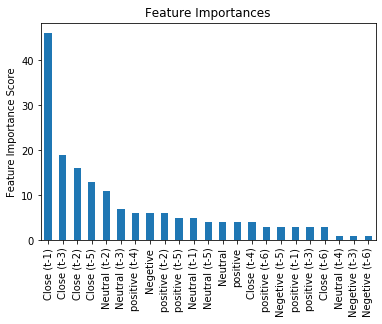

<Figure size 1440x1440 with 0 Axes>

In [176]:
xgb_model= xgb.XGBRegressor(learning_rate=0.16,
                                                n_estimators=45,
                                                max_depth=3,
                                                min_child_weight=3,
                                                gamma=0,
                                                subsample=1,
                                                colsample_bytree=1,
                                                colsample_bynode=1,
                                                colsample_bylevel=1,
                                                njobs=-1,
                                                scale_pos_weight=1,
                                                seed=123,
                           reg_alpha=0.1)
train_predict,test_predict,feat_imp = model_fit(xgb_model,train_x,test_x,train_y,test_y)

In [177]:
feat_imp[feat_imp>2]

Close (t-1)       46
Close (t-3)       19
Close (t-2)       16
Close (t-5)       13
Neutral (t-2)     11
Neutral (t-3)      7
positive (t-4)     6
Negetive           6
positive (t-2)     6
positive (t-5)     5
Neutral (t-1)      5
Neutral (t-5)      4
Neutral            4
positive           4
Close (t-4)        4
positive (t-6)     3
Negetive (t-5)     3
positive (t-1)     3
positive (t-3)     3
Close (t-6)        3
dtype: int64

In [178]:
test_result=test_y
test_result['predict']=test_predict
test_result['diff']=test_result['Close']-test_result['predict']
test_result.describe()

,Close,predict,diff
count,81.000000,81.000000,81.000000
mean,911.484568,913.558472,-2.073935
std,25.505984,23.482700,10.911385
min,852.750000,876.859192,-27.996948
25%,893.750000,891.307617,-10.290710
50%,915.500000,911.578430,-2.176331
75%,929.000000,929.354309,4.852295
max,960.250000,959.124817,21.103577


test_result

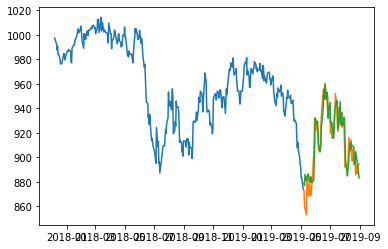

In [180]:
plt.plot(train['Close'])
plt.plot(test_result[['Close', 'predict']])
plt.show()

# Prophet

In [25]:
from fbprophet import Prophet

In [ ]:
import matplotlib.pyplot as plt

In [14]:
df = close_merge[['Close']]
df.head()

,Close
Date,
11/14/2017,978.5
11/15/2017,985.0
11/16/2017,983.0
11/17/2017,996.5
11/20/2017,998.5


In [17]:
df.index = pd.to_datetime(df.index)

In [19]:
daily_df = df.resample('D').ffill()

In [20]:
d_df = daily_df.reset_index().dropna()

In [39]:
d_df.columns = ['ds', 'y']

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(d_df)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
657,2019-09-02,871.246119,859.796698,882.896703
658,2019-09-03,868.149992,857.155909,879.617957
659,2019-09-04,865.646287,854.498686,877.779829
660,2019-09-05,863.132547,850.897554,875.185343
661,2019-09-06,861.948033,850.537943,872.977876


In [40]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2018-12-03 00:00:00 and 2019-06-01 00:00:00


,horizon,mse,rmse,mae,mape,coverage
0,9 days,461.578657,21.484382,18.204968,0.019334,0.333333
1,10 days,522.057077,22.848568,19.560861,0.020798,0.288889
2,11 days,622.594750,24.951849,21.120664,0.022476,0.244444
3,12 days,760.597652,27.578935,22.746076,0.024222,0.222222
4,13 days,951.736009,30.850219,24.733374,0.026352,0.200000
